# 20171007
- KA(West) 데이터 셋에 대해서 실험하기

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* If needed, download the reference model ("AlexNet").

In [3]:
import os
if os.path.isfile(caffe_root + 'models/places365_cnn/alexnet_places365.caffemodel'):
    print('AlexNet found.')
else:
    print('Cannot find alexnet_places365.caffemodel')


AlexNet found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/places365_cnn/deploy_alexnet_places365.prototxt'
model_weights = caffe_root + 'models/places365_cnn/alexnet_places365.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)



* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default AlexNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [5]:
import caffe
import numpy as np
import sys

blob = caffe.proto.caffe_pb2.BlobProto()
data = open('/home/dongwonshin/Desktop/caffe/models/places365_cnn/places365CNN_mean.binaryproto' , 'rb' ).read()
blob.ParseFromString(data)
arr = np.array( caffe.io.blobproto_to_array(blob) )
out=arr[0]
np.save('/home/dongwonshin/Desktop/caffe/models/places365_cnn/places365CNN_mean.npy', out)

In [6]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'models/places365_cnn/places365CNN_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print('mean-subtracted values:', zip('BGR', mu))

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

('mean-subtracted values:', [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)])


### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [7]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

-------

In [8]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()

def AlexNetFeature(batch_list):
    if(len(batch_list) > 50):
        print("length of the batch_list should be less than 50.")
        return 0
    
    image_list = []
    for filepath in batch_list:
        image = caffe.io.load_image(filepath)
        transformed_image = transformer.preprocess('data', image)
    #     plt.imshow(image)
        image_list.append(transformed_image)


    # copy the image data into the memory allocated for the net
    for i in range(len(batch_list)):
        net.blobs['data'].data[i] = image_list[i]

    ### perform classification
    net.forward()  # run once before timing to set up memory

    feature_list = []
    for i in range(len(batch_list)):
        feat = net.blobs['conv5'].data[i]
        feature_list.append(np.ndarray.flatten(feat) / np.linalg.norm(feat))
    
    return feature_list

file_list = sorted(glob('/media/dongwonshin/Ubuntu Data/Datasets/KAIST_All_Day/Synced_Data/KAIST_All_Day(West)/images/small_size/*.jpg'))
feature_lists = []
for idx in range(0,len(file_list),50):
    feature_lists.append(AlexNetFeature(file_list[idx:idx+50]))

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [9]:
feature_lists = np.concatenate(feature_lists)
mat_size = len(feature_lists)

In [10]:
def L1Scoring(vec1, vec2):
    score = 0
    for i in range(len(vec1)):
        score += abs(vec1[i] - vec2[i]) - abs(vec1[i]) - abs(vec2[i])
    score = -score/2.0
    
    return score

heat_map = np.zeros((mat_size,mat_size))

for i in range(mat_size):
    for j in range(i,mat_size):
#         heat_map[i,j] = np.linalg.norm(feature_lists[i]-feature_lists[j])
        heat_map[i,j] = L1Scoring(feature_lists[i], feature_lists[j])
    print('%d row complete' % i)

0 row complete
1 row complete
2 row complete
3 row complete
4 row complete
5 row complete
6 row complete
7 row complete
8 row complete
9 row complete
10 row complete
11 row complete
12 row complete
13 row complete
14 row complete
15 row complete
16 row complete
17 row complete
18 row complete
19 row complete
20 row complete
21 row complete
22 row complete
23 row complete
24 row complete
25 row complete
26 row complete
27 row complete
28 row complete
29 row complete
30 row complete
31 row complete
32 row complete
33 row complete
34 row complete
35 row complete
36 row complete
37 row complete
38 row complete
39 row complete
40 row complete
41 row complete
42 row complete
43 row complete
44 row complete
45 row complete
46 row complete
47 row complete
48 row complete
49 row complete
50 row complete
51 row complete
52 row complete
53 row complete
54 row complete
55 row complete
56 row complete
57 row complete
58 row complete
59 row complete
60 row complete
61 row complete
62 row complete
63

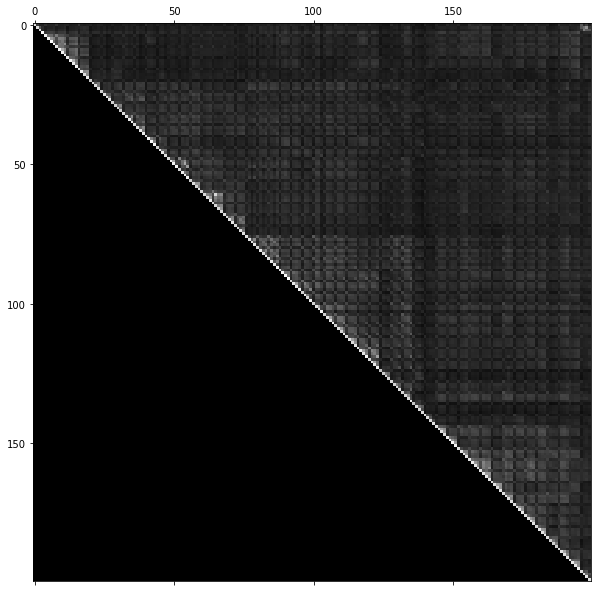

In [13]:
plt.matshow(heat_map)

In [11]:
normalized_heat_map = np.zeros((mat_size,mat_size))

for i in range(mat_size):
    normalized_heat_map[i,:] = heat_map[i,:]/(heat_map[i,:].max())

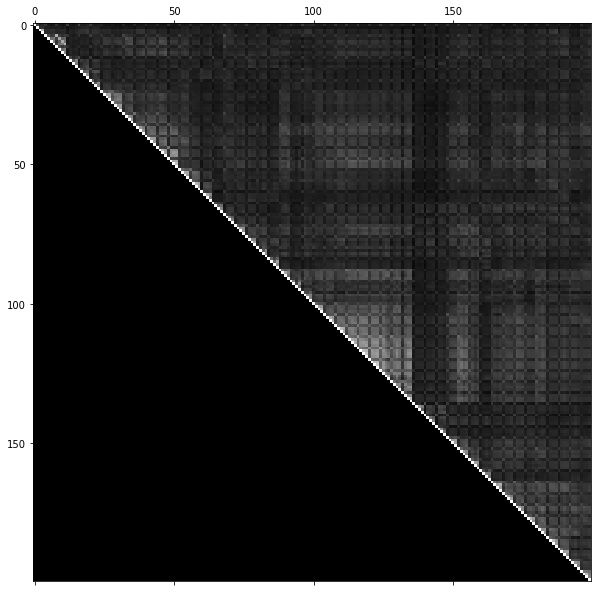

In [12]:
plt.matshow(normalized_heat_map)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io as sio

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

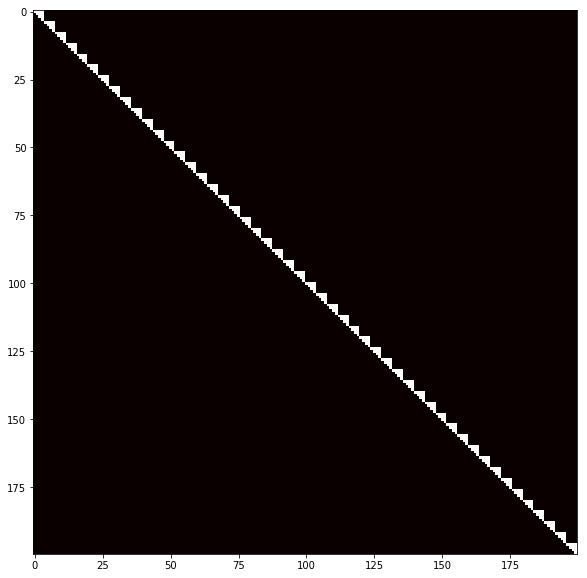

In [14]:
TARGET_EVAL_DATASET = 'KAIST_All_Day(West)'
from glob import glob
images = glob('/media/dongwonshin/Ubuntu Data/Datasets/KAIST_All_Day/Synced_Data/%s/images/small_size/*.jpg' % TARGET_EVAL_DATASET)

GT_corr_mat = np.zeros((len(images), len(images)))
for i in range(0,len(images),4):
    for j in range(i,i+4):
        GT_corr_mat[i,j] = 1
    for j in range(i+1,i+4):
        GT_corr_mat[i+1,j] = 1
    for j in range(i+2,i+4):
        GT_corr_mat[i+2,j] = 1
    for j in range(i+3,i+4):
        GT_corr_mat[i+3,j] = 1
        
plt.figure(figsize=(10,10))
plt.imshow(GT_corr_mat, cmap = 'hot')
plt.show()

In [15]:
def PrecisionRecalCurve(GT_corr_mat, esti_corr_mat):

    precision, recall, _ = precision_recall_curve(GT_corr_mat.flatten(), esti_corr_mat.flatten())
    average_precision = average_precision_score(GT_corr_mat.flatten(), esti_corr_mat.flatten())

    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
    plt.legend(loc="lower left")
    plt.show()

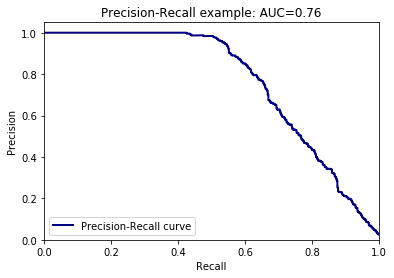

In [16]:
corr_matrix = normalized_heat_map
PrecisionRecalCurve(GT_corr_mat, corr_matrix)

In [17]:
np.savetxt('cnnbased_KA(West).txt', corr_matrix)